In [30]:
import os
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
%matplotlib inline
import utils
import sys, importlib

from matplotlib import rc
rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

importlib.reload(sys.modules['utils'])
get_sequences = utils.get_sequences
convert_bagsize_key = utils.convert_bagsize_key
parse_json = utils.parse_json
get_plot_defaults = utils.get_plot_defaults
make_like_colab = utils.make_like_colab
    
out = 'plots_examples'
if not os.path.isdir(out):
    os.makedirs(out)

defaults = get_plot_defaults()
print(defaults)

{'font_size_title': 32, 'font_size_axes': 25, 'font_size_ticks': 22, 'font_size_legend': 22, 'line_width': 3, 'marker_size': 10, 'dpi': 600}


# Baseline 1: Root SIFT v.s. Hardnet v.s. Superpoint

In [31]:
methods, results = {}, {}
# the result root will only show up after running evaluation benchmark
result_root = '/home/ken/workspace/image-matching-benchmark/packed-val'

# Add Root SIFT results
ths = [0.1, 0.15, 0.2, 0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2, 2.5, 3, 4, 5, 7.5, 10, 15, 20]

methods_cur = {}
methods_cur['rootsift-upright-2k'] = 'Upright RootSIFT'
methods_cur['sift8k-8000-hardnet'] = 'SIFT 8K HardNet'
methods_cur['superpoint-2k'] = 'Superpoint 2K'
# TODO: run Root SIFT 8k
for desc_key, desc_name in methods_cur.items():
    for th in ths:
        key = '{}, DEGENSAC w/ th={}'.format(desc_name, th)
        try:
            results[key] = parse_json(
                os.path.join(result_root,
                    '{}-degensac-inlier-th-{}.json'.format(desc_key, th)))
        except Exception:
            pass
    
methods.update(methods_cur)

print(methods)
print(results.keys())

{'rootsift-upright-2k': 'Upright RootSIFT', 'sift8k-8000-hardnet': 'SIFT 8K HardNet', 'superpoint-2k': 'Superpoint 2K'}
dict_keys(['Upright RootSIFT, DEGENSAC w/ th=0.1', 'Upright RootSIFT, DEGENSAC w/ th=0.25', 'Upright RootSIFT, DEGENSAC w/ th=0.5', 'Upright RootSIFT, DEGENSAC w/ th=0.75', 'Upright RootSIFT, DEGENSAC w/ th=1', 'Upright RootSIFT, DEGENSAC w/ th=1.5', 'Upright RootSIFT, DEGENSAC w/ th=2', 'Upright RootSIFT, DEGENSAC w/ th=5', 'SIFT 8K HardNet, DEGENSAC w/ th=0.1', 'SIFT 8K HardNet, DEGENSAC w/ th=0.25', 'SIFT 8K HardNet, DEGENSAC w/ th=0.5', 'SIFT 8K HardNet, DEGENSAC w/ th=0.75', 'SIFT 8K HardNet, DEGENSAC w/ th=1', 'SIFT 8K HardNet, DEGENSAC w/ th=1.5', 'SIFT 8K HardNet, DEGENSAC w/ th=2', 'SIFT 8K HardNet, DEGENSAC w/ th=5', 'Superpoint 2K, DEGENSAC w/ th=0.1', 'Superpoint 2K, DEGENSAC w/ th=0.25', 'Superpoint 2K, DEGENSAC w/ th=0.5', 'Superpoint 2K, DEGENSAC w/ th=0.75', 'Superpoint 2K, DEGENSAC w/ th=1', 'Superpoint 2K, DEGENSAC w/ th=1.5', 'Superpoint 2K, DEGENSA

DEGENSAC, SIFT 8K HardNet -> Best mAP=0.6671 at th=0.5
DEGENSAC, Superpoint 2K -> Best mAP=0.3450 at th=1
DEGENSAC, Upright RootSIFT -> Best mAP=0.5568 at th=0.5

Found: 3/3



/home/ken/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


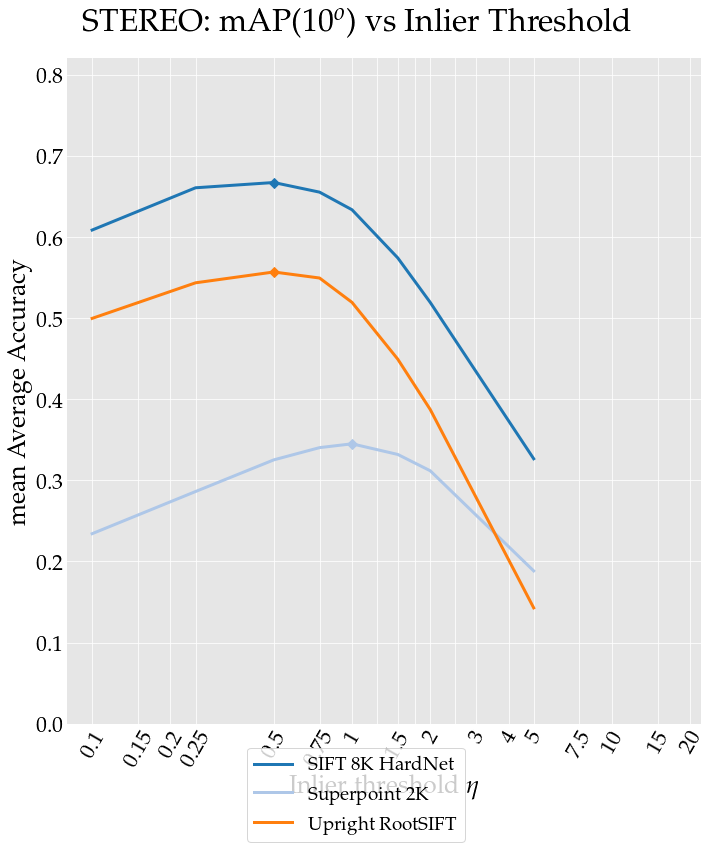

In [32]:
fig, axes = plt.subplots(1, 1, figsize=(10,12))
cmap = matplotlib.cm.get_cmap('tab20')

# config
labels = []
t = 10
ax = axes
sac = 'DEGENSAC'

count = 0
for i, method in enumerate(sorted(methods.values())):
    if 'DSP'  in method:
        continue
    x, y = [], []
    for th in ths:
        key = '{}, DEGENSAC w/ th={}'.format(method, th)
        if key in results:
            x.append(th)
            y.append(results[key]['phototourism']['results']['allseq']['stereo']['run_avg']['qt_auc_10_th_0.1']['mean'])
    if len(y) > 0:
        cur_label = method
        if cur_label not in labels:
            labels.append(cur_label)
        ax.plot(
            np.log(x),
            y,
            linestyle='-',
            color=cmap(i),
            marker=None,
            linewidth=defaults['line_width']
        )
        # plot max
        ax.plot(
            np.log(x[np.argmax(y)]),
            max(y),
            linestyle=None,
            color=cmap(i),
            marker='D',
            markersize=7,
            label='_nolegend_',
        )
        count += 1

        # choose best, but check if there's a maxima already (run might not have finished)
        if x[np.argmax(y)] != min(x) and x[np.argmax(y)] != max(x):
            print('{}, {} -> Best mAP={:.04f} at th={}'.format(sac, method, max(y), x[np.argmax(y)]))
        else:
            print('{}, {} entries, {} -> No maxima yet ({} entries finished)'.format(sac, len(x), method, len(x)))
    else:
        print('{}, {} -> No data points yet'.format(sac, method))
print()
print('Found: {}/{}'.format(count, len(methods)))
print()

# ax.set_title('({}) {}'.format(['a', 'b', 'c', 'd'][cur], sac.replace('NODEGENSAC',
#                                                                     'PyRANSAC')), fontsize=defaults['font_size_title'] - 8)
ax.set_ylabel('mean Average Accuracy', fontsize=defaults['font_size_axes'])
ax.set_xticks(np.log(ths))
ax.set_xlabel('Inlier threshold $\eta$', fontsize=defaults['font_size_axes'])
ths_xlabel = [str(v) if v not in [1.25, 1.75, 2.5] else '' for v in ths]
ax.set_xticklabels(ths_xlabel, rotation=60)
ax.tick_params(axis='both', which='major', labelsize=defaults['font_size_ticks'])
ax.set_ylim(0, .82)
ax.set_xlim(np.log(0.08), np.log(22))
make_like_colab(fig, ax)

from pylab import gcf
gcf().suptitle('STEREO: mAP(10$^o$) vs Inlier Threshold', fontsize=defaults['font_size_title'])
fig.legend(labels=labels, prop={'size': defaults['font_size_legend'] - 3}, loc='lower center', ncol=1)
fig.tight_layout()
plt.subplots_adjust(top=0.92, bottom=0.15)

# plt.savefig('{}/ransac-th-example.png'.format(out), bbox_inches='tight', dpi=defaults['dpi'])
plt.show()

In [33]:
methods, results = {}, {}
rts = [0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1]

methods_cur = {}
methods_cur['rootsift-upright-2k'] = 'Upright RootSIFT'
methods_cur['sift8k-8000-hardnet'] = 'SIFT 8K HardNet'
methods_cur['superpoint-2k'] = 'Superpoint 2K'
for desc_key, desc_name in methods_cur.items():
    for rt in rts:
        key = '{}, {}'.format(desc_name, 'RT={}'.format(rt) if rt < 100 else 'No RT')
        try:
            json_path = os.path.join(result_root, '{}-degensac-th-0.5-rt-{}.json'.format(desc_key, rt))
            results[key] = parse_json(json_path)
        except Exception:
            pass
methods.update(methods_cur)

print(methods)
print(results.keys())

{'rootsift-upright-2k': 'Upright RootSIFT', 'sift8k-8000-hardnet': 'SIFT 8K HardNet', 'superpoint-2k': 'Superpoint 2K'}
dict_keys(['Upright RootSIFT, RT=0.6', 'Upright RootSIFT, RT=0.65', 'Upright RootSIFT, RT=0.7', 'Upright RootSIFT, RT=0.75', 'Upright RootSIFT, RT=0.8', 'Upright RootSIFT, RT=0.85', 'Upright RootSIFT, RT=0.9', 'Upright RootSIFT, RT=0.95', 'Upright RootSIFT, RT=1', 'SIFT 8K HardNet, RT=0.6', 'SIFT 8K HardNet, RT=0.65', 'SIFT 8K HardNet, RT=0.7', 'SIFT 8K HardNet, RT=0.75', 'SIFT 8K HardNet, RT=0.8', 'SIFT 8K HardNet, RT=0.85', 'SIFT 8K HardNet, RT=0.9', 'SIFT 8K HardNet, RT=0.95', 'SIFT 8K HardNet, RT=1', 'Superpoint 2K, RT=0.6', 'Superpoint 2K, RT=0.65', 'Superpoint 2K, RT=0.7', 'Superpoint 2K, RT=0.75', 'Superpoint 2K, RT=0.8', 'Superpoint 2K, RT=0.85', 'Superpoint 2K, RT=0.9', 'Superpoint 2K, RT=0.95', 'Superpoint 2K, RT=1'])


STEREO: SIFT 8K HardNet -> Best mAP=0.6763 at RT=0.85
STEREO: Superpoint 2K -> Best mAP=0.3252 at RT=0.9
STEREO: Upright RootSIFT -> Best mAP=0.5800 at RT=0.85

Found: 3/3

MULTIVIEW: SIFT 8K HardNet -> Best mAP=0.7809 at RT=0.8
MULTIVIEW: Superpoint 2K -> Best mAP=0.5461 at RT=0.9
MULTIVIEW: Upright RootSIFT -> Best mAP=0.6617 at RT=0.8

Found: 3/3



/home/ken/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


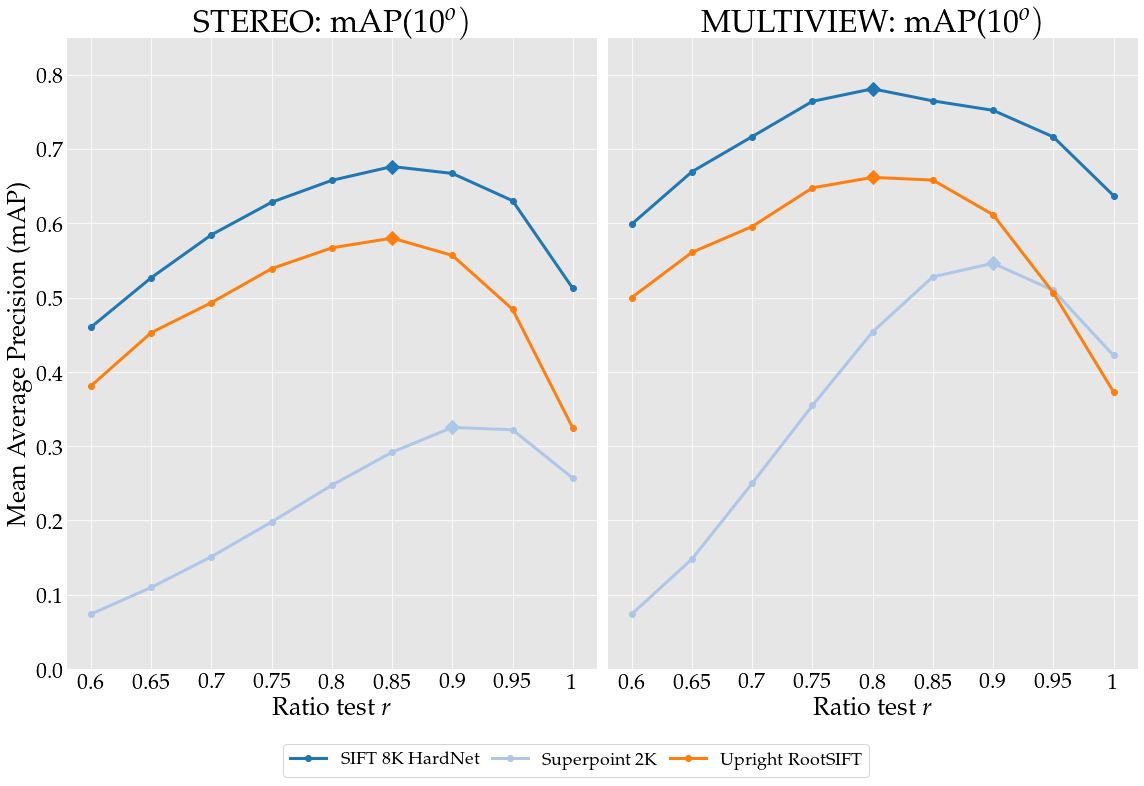

In [34]:
method_best_rt_stereo = {}
method_best_rt_multiview = {}
fig, axes = plt.subplots(1, 2, figsize=(16,11))
cmap = matplotlib.cm.get_cmap('tab20')

# config
labels = []
for cur in range(2):
    ax = axes[cur]
    count  = 0
    for i, method in enumerate(sorted(methods.values())):
        x, y = [], []
        for rt in rts:
            key = '{}, {}'.format(method, 'RT={}'.format(rt) if rt < 100 else 'No RT')
            if key in results:
                if cur == 0:
                    x.append(rt)
                    y.append(results[key]['phototourism']['results']['allseq']['stereo']['run_avg']['qt_auc_{:02d}_th_0.1'.format(t)]['mean'])
                else:
                    x.append(rt)
                    y.append(results[key]['phototourism']['results']['allseq']['multiview']['run_avg']['bag_avg']['qt_auc_colmap_10']['mean'])
        if len(y) > 0:
            if method not in labels:
                labels.append(method)
            ax.plot(
                x,
                y,
                linestyle='-',
                color=cmap(i),
                marker='.',
                markersize=12,
                linewidth=defaults['line_width'],
            )
            # plot max
            ax.plot(
                x[np.argmax(y)],
                max(y),
                linestyle=None,
                color=cmap(i),
                marker='D',
                markersize=10,
                label='_nolegend_',
            )
            count += 1
            
        if len(y) >= 6:
            print('{}: {} -> Best mAP={:.04f} at RT={}'.format('STEREO' if cur == 0 else 'MULTIVIEW', method, max(y), x[np.argmax(y)]))
            if cur == 0:
                method_best_rt_stereo[method] = x[np.argmax(y)]
            else:
                method_best_rt_multiview[method] = x[np.argmax(y)]
        else:
            print('{}, {} -> No maxima yet ({}/9 entries finished)'.format('STEREO' if cur == 0 else 'MULTIVIEW', method, len(y)))
    print()
    print('Found: {}/{}'.format(count, len(methods)))
    print()

    ax.set_title('{}: mAP({}$^o)$'.format('STEREO' if cur == 0 else 'MULTIVIEW', t), fontsize=defaults['font_size_title'])
    ax.set_xlabel('Ratio test $r$', fontsize=defaults['font_size_axes'])
    if cur == 0:
        ax.set_ylabel('Mean Average Precision (mAP)', fontsize=defaults['font_size_axes'])
    else:
        ax.set_yticklabels([])
    ax.set_xticks(rts)
    ax.set_xticklabels([rt if rt < 100 else 'None' for rt in rts])
    ax.tick_params(axis='both', which='major', labelsize=defaults['font_size_ticks'])
    ax.set_ylim(0, .85)
    ax.set_xlim(0.58, 1.02)
    make_like_colab(fig, ax)

fig.legend(labels, prop={'size': defaults['font_size_legend'] - 4}, loc='lower center', bbox_to_anchor=(0.50, 0), ncol=4, columnspacing=.7)
fig.tight_layout()
plt.subplots_adjust(bottom=0.15)

# plt.savefig('{}/ransac-rt-example.png'.format(out), bbox_inches='tight', dpi=defaults['dpi'])
plt.show()